# Linear Programming

## Introduction

In [12]:
from scipy.spatial import HalfspaceIntersection, ConvexHull
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np

def render_inequalities(halfspaces, feasible_point, xlim, ylim):
    hs = HalfspaceIntersection(np.array(halfspaces), np.array(feasible_point))
    fig = plt.figure()
    ax = fig.add_subplot('111', aspect='equal')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    x = np.linspace(*xlim, 100)

    for h in halfspaces:
        if h[1]== 0:
            ax.axvline(-h[2]/h[0], color="#2c3e50")
        else:
            ax.plot(x, (-h[2]-h[0]*x)/h[1], color="#2c3e50")
    x, y = zip(*hs.intersections)
    points = list(zip(x, y))
    convex_hull = ConvexHull(points)
    polygon = Polygon([points[v] for v in convex_hull.vertices], color="#34495e")
    ax.add_patch(polygon)
    ax.plot(x, y, 'o', color="#e67e22")

<ipython-input-12-e5d7924ac3df>:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot('111', aspect='equal')


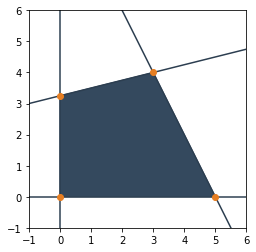

In [13]:
halfspaces = [
    [-1, 0., 0.],    # x₁ ≥ 0
    [0., -1., 0.],   # x₂ ≥ 0
    [-1., 4., -13.], # 4x₂ - x₁ ≤ 13
    [2., 1., -10.]   # x₂ + 2x₁ ≤ 10
]
feasible_point = [0.5, 0.5]
xlim = (-1, 6)
render_inequalities(halfspaces, feasible_point, xlim, xlim)
plt.show()

## Preparation for Simplex Method

In [14]:
a = [
    [-1, 4, 1, 0],
    [2, 1, 0, 1],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
]
b = [13, 10, 0, 0]
x1, x2, x3, x4 = np.linalg.solve(a, b)
print('x1 =', x1)
print('x2 =', x2)

x1 = 3.0
x2 = 4.0


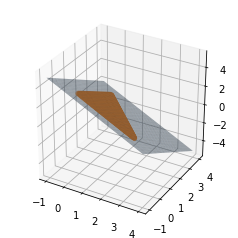

In [4]:
from mpl_toolkits.mplot3d import Axes3D

plt3d = plt.figure().gca(projection='3d', aspect='equal')

# plane: a*x1 + b*x2 + c*x3 + d = 0
normal = [1, 1, 1]
point = [1, 1, 1]
d = -3

xx, yy = np.meshgrid(np.linspace(-1, 4, 100), np.linspace(-1, 4, 100))
zz = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]
plt3d.plot_surface(
    xx,
    yy,
    zz,
    alpha=0.5,
    color="#34495e"
)

ax = plt.gca()
for row_i, row in enumerate(xx):
    x_row = []
    y_row = []
    z_row = []
    for column_i, x in enumerate(row):
        y = yy[row_i][column_i]
        z = zz[row_i][column_i]
        if x < 0 or y < 0 or z < 0:
            continue

        x_row.append(x)
        y_row.append(y)
        z_row.append(z)
    if len(x_row) > 0:
        ax.scatter(
            x_row,
            y_row,
            z_row,
            color="#e67e22"
        )

plt.show()

## Simplex Method

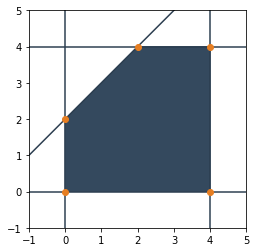

In [5]:
halfspaces = [
    [-1, 0, 0],    # x₁ ≥ 0
    [0, -1, 0],    # x₂ ≥ 0
    [-1, 1, -2],   # -x₁ + x₂ ≤ 2
    [1, 0, -4],    # x₁ ≤ 4
    [0, 1, -4],    # x₂ ≤ 4
]
feasible_point = np.array([0.5, 0.5])
xlim = (-1, 5)
render_inequalities(halfspaces, feasible_point, xlim, xlim)
plt.show()

In [9]:
c = [1, 1, 0, 0, 0]
A = [
    [-1, 1, 1, 0, 0],
    [ 1, 0, 0, 1, 0],
    [ 0, 1, 0, 0, 1]
]
b = [2, 4, 4]

In [8]:
def to_tableau(c, A, b):
    xb = [eq + [x] for eq, x in zip(A, b)]
    z = c + [0]
    return xb + [z]

In [7]:
def can_be_improved(tableau):
    z = tableau[-1]
    return any(x > 0 for x in z[:-1])

In [6]:
import math

def get_pivot_position(tableau):
    z = tableau[-1]
    column = next(i for i, x in enumerate(z[:-1]) if x > 0)
    
    restrictions = []
    for eq in tableau[:-1]:
        el = eq[column]
        restrictions.append(math.inf if el <= 0 else eq[-1] / el)
        
    if (all([r == math.inf for r in restrictions])):
        raise Exception("Linear program is unbounded.")

    row = restrictions.index(min(restrictions))
    return row, column

In [5]:
def pivot_step(tableau, pivot_position):
    new_tableau = [[] for eq in tableau]
    
    i, j = pivot_position
    pivot_value = tableau[i][j]
    new_tableau[i] = np.array(tableau[i]) / pivot_value
    
    for eq_i, eq in enumerate(tableau):
        if eq_i != i:
            multiplier = np.array(new_tableau[i]) * tableau[eq_i][j]
            new_tableau[eq_i] = np.array(tableau[eq_i]) - multiplier
   
    return new_tableau

In [4]:
def is_basic(column):
    return sum(column) == 1 and len([c for c in column if c == 0]) == len(column) - 1

def get_solution(tableau):
    columns = np.array(tableau).T
    solutions = []
    for column in columns[:-1]:
        solution = 0
        if is_basic(column):
            one_index = column.tolist().index(1)
            solution = columns[-1][one_index]
        solutions.append(solution)
        
    return solutions

In [12]:
def simplex(c, A, b):
    tableau = to_tableau(c, A, b)

    while can_be_improved(tableau):
        pivot_position = get_pivot_position(tableau)
        tableau = pivot_step(tableau, pivot_position)

    return get_solution(tableau)

In [3]:
solution = simplex(c, A, b)
print('solution: ', solution)

NameError: name 'simplex' is not defined

In [10]:
def get_objective_function_value(tableau):
    return -tableau[-1][-1]

In [1]:
def simplex_with_visualization(c, A, b, halfspaces, feasible_point):
    tableau = to_tableau(c, A, b)

    zs = [get_objective_function_value(tableau)]
    solutions = [get_solution(tableau)]
    while can_be_improved(tableau):
        pivot_position = get_pivot_position(tableau)
        tableau = pivot_step(tableau, pivot_position)
        solutions.append(get_solution(tableau))
        zs.append(get_objective_function_value(tableau))
        print(zs)
    
    points = [v[:2] for v in solutions]
    xlim = (-1, max([p[0] for p in points]) + 1)
    ylim = (-1, max([p[1] for p in points]) + 1)
    render_inequalities(halfspaces, feasible_point, xlim, ylim)

    for start, end in zip(points[:-1], points[1:]):
        dx = end[0] - start[0]
        dy = end[1] - start[1]
        if dx > 0 and dy > 0:
            plt.arrow(
                start[0],
                start[1],
                dx,
                dy,
                width=0.1,
                length_includes_head=True,
                color='#1abc9c'
            )
    plt.show()
    
    steps = range(len(zs))
    plt.plot(steps, zs, color="#2c3e50")
    plt.xticks(steps)
    plt.xlabel('iterations')
    plt.ylabel('objective function value')
    
    return get_solution(tableau)

[0, 10.0]
[0, 10.0, 10.0]


<ipython-input-12-e5d7924ac3df>:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot('111', aspect='equal')


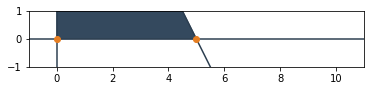

[10.0, 0.0, 23.0, 0, 0]

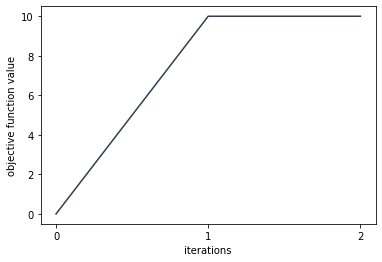

In [15]:
simplex_with_visualization(c, A, b, halfspaces, feasible_point)

## Simplex Method and Potential Problems

In [17]:
c = [1, 1, 0]
A = [
    [-1, 4, 1]
]
b = [13]
try: 
    simplex(c, A, b)
except Exception as e:
    print(e)

Linear program is unbounded.


[0, -0.0]
[0, -0.0, 2.0]


<ipython-input-12-e5d7924ac3df>:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot('111', aspect='equal')


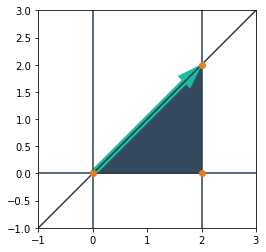

[2.0, 2.0, 0, 0]

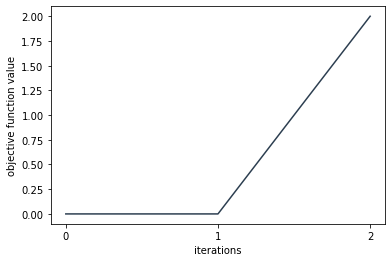

In [16]:
c = [0, 1, 0, 0]
A = [
    [-1, 1, 1, 0],
    [ 1, 0, 0, 1]
]
b = [0, 2]
halfspaces = [
    [-1, 0, 0],
    [ 0,-1, 0],
    [-1, 1, 0],
    [ 1, 0,-2]
]
simplex_with_visualization(c, A, b, halfspaces, [1, 0.5])

## Dual Simplex Method

In [19]:
def to_objective_function_value(c, solution):
    return sum(np.array(c) * np.array(solution))

In [20]:
c = [2, 3, 0, 0, 0]
A = [
    [4, 8, 1, 0, 0],
    [2, 1, 0, 1, 0],
    [3, 2, 0, 0, 1]
]
b = [12, 3, 4]

primal = to_objective_function_value(c, simplex(c, A, b))
print('Primal: ', primal)

Primal:  4.75


In [21]:
import math

def can_be_improved_for_dual(tableau):
    rhs_entries = [row[-1] for row in tableau[:-1]]
    return any([entry < 0 for entry in rhs_entries])

def get_pivot_position_for_dual(tableau):
    rhs_entries = [row[-1] for row in tableau[:-1]]
    min_rhs_value = min(rhs_entries)
    row = rhs_entries.index(min_rhs_value)
    
    columns = []
    for index, element in enumerate(tableau[row][:-1]):
        if element < 0:
            columns.append(index)
    columns_values = [tableau[row][c] / tableau[-1][c] for c in columns]
    column_min_index = columns_values.index(min(columns_values))
    column = columns[column_min_index]

    return row, column

def dual_simplex(c, A, b):
    tableau = to_tableau(c, A, b)

    while can_be_improved_for_dual(tableau):
        pivot_position = get_pivot_position_for_dual(tableau)
        tableau = pivot_step(tableau, pivot_position)

    return get_solution(tableau)

In [22]:
c = [12, 3, 4, 0, 0]
A = [
    [-4, -2, -3,  1,  0],
    [-8, -1, -2,  0,  1]
]
b = [-2, -3]

dual = to_objective_function_value(c, dual_simplex(c, A, b))
print('Dual: ', dual)

Dual:  4.75
